## 0. Load datasets

In [124]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None,
                    measurement_level_name:str='Measurement'):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      feature_selection.SelectFromModel(classifier()),
                                      classifier() )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    

In [125]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))

pca_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Probabilistic PCA'
divisions_pca = pd.read_pickle(path.join(pca_dir,'divisions/transformed.pkl'))
divisions_components = pd.read_pickle(path.join(pca_dir,'divisions/components.pkl'))

## 1. Randomforest

### Random forest

In [126]:
# Run classifier
# axis0: observation axis1: prediction
divisions_pca = divisions_pca[~np.isnan(divisions_pca['At least one daughter differentiated','Meta'].astype(float))]
predictions,models = predict_feature(divisions_pca, ensemble.RandomForestClassifier, feature2predict, Niter=100, measurement_level_name='PCA')

100%|█████████████████████████████████████████| 100/100 [00:22<00:00,  4.46it/s]


Text(0.5, 0, 'AUCs')

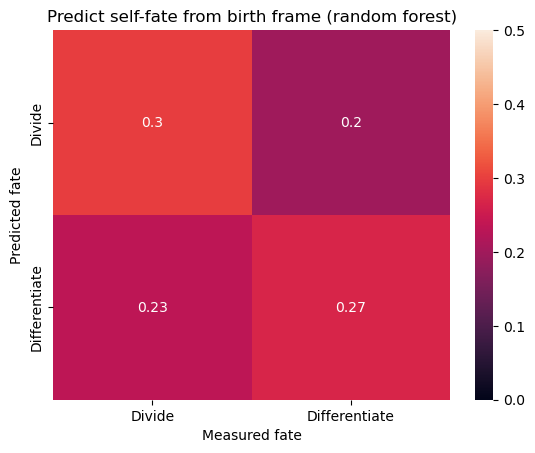

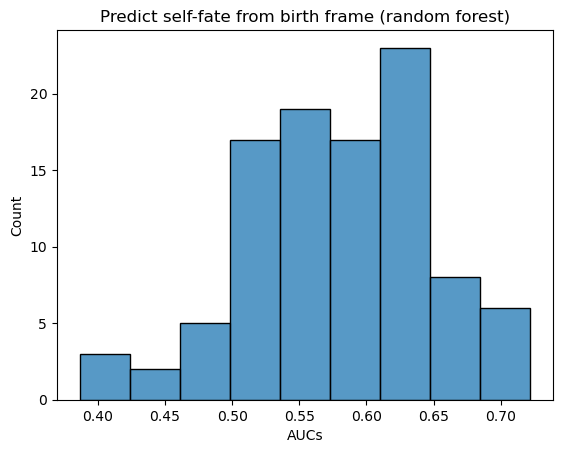

In [127]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.title('Predict self-fate from birth frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict self-fate from birth frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')

### Plot the impurity importances

Text(0, 0.5, 'Effect size')

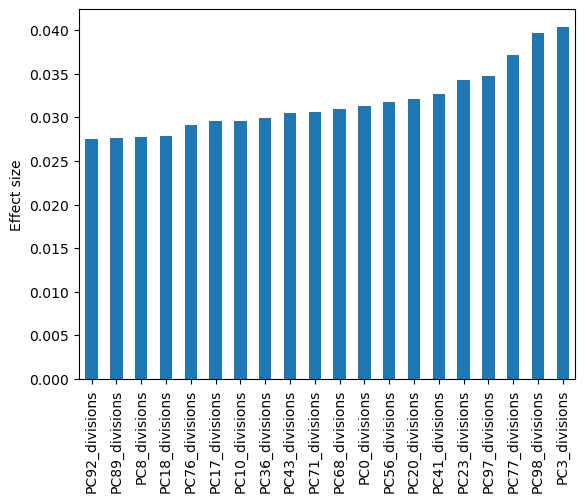

In [131]:
feat_names = divisions_pca.xs('PCA',level=1,axis=1).columns
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,feat_names[m[1].get_support()]] = m[2].feature_importances_

importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(20).plot.bar()

plt.ylabel('Effect size')

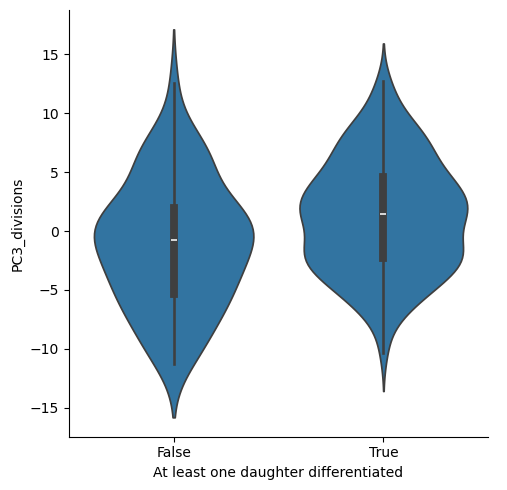

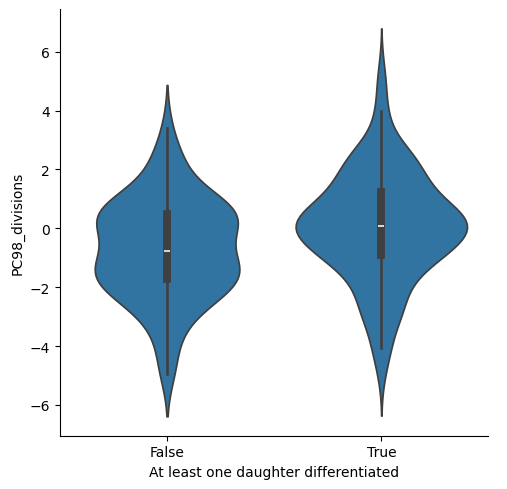

In [132]:
sb.catplot(divisions_pca.droplevel(axis=1,level=1),x=feature2predict,y='PC3_divisions',kind='violin')
sb.catplot(divisions_pca.droplevel(axis=1,level=1),x=feature2predict,y='PC98_divisions',kind='violin')

In [ ]:
from sklearn import feature_selection

X = divisions_pca.xs('PCA',level=1,axis=1)
y = divisions_pca[feature2predict,'Meta'].astype(bool)
m = ensemble.RandomForestClassifier().fit(X,y)

results = feature_selection.RFECV(m).fit(X,y)

In [ ]:
plt.errorbar(x=results.cv_results_['n_features'][:50],
        y=results.cv_results_['mean_test_score'][:50],
        yerr=results.cv_results_['std_test_score'][:50])


In [59]:
print(f'# optimal features: {results.n_features_}')

selected = X.columns[ results.ranking_ == 1]
print(selected)

# optimal features: 23
Index(['PC0_divisions', 'PC1_divisions', 'PC2_divisions', 'PC3_divisions',
       'PC5_divisions', 'PC7_divisions', 'PC13_divisions', 'PC17_divisions',
       'PC18_divisions', 'PC20_divisions', 'PC28_divisions', 'PC29_divisions',
       'PC36_divisions', 'PC54_divisions', 'PC56_divisions', 'PC68_divisions',
       'PC71_divisions', 'PC81_divisions', 'PC86_divisions', 'PC87_divisions',
       'PC89_divisions', 'PC92_divisions', 'PC98_divisions'],
      dtype='object')


## Logistic

In [133]:
# Run classifier
# axis0: observation axis1: prediction

feature2predict = 'At least one daughter differentiated'
predictions,models = predict_feature(divisions_pca, linear_model.LogisticRegression, feature2predict, measurement_level_name='PCA')

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 97.25it/s]


Text(0.5, 0, 'AUCs')

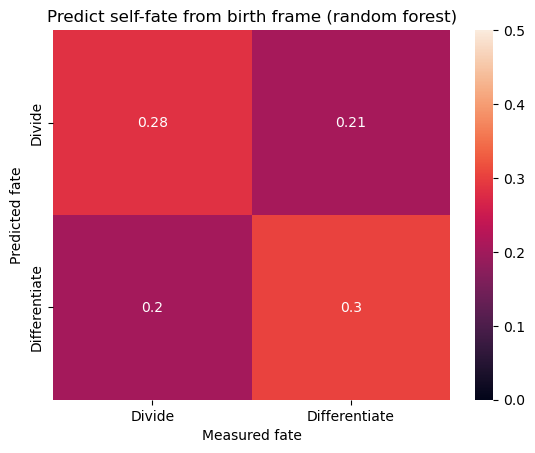

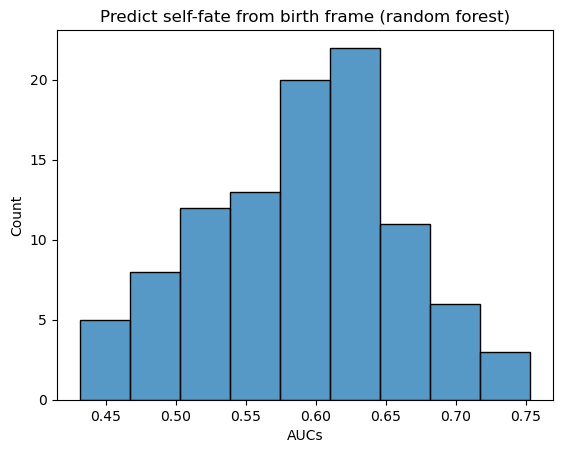

In [134]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.title('Predict self-fate from birth frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict self-fate from birth frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')

Text(0, 0.5, 'Effect size')

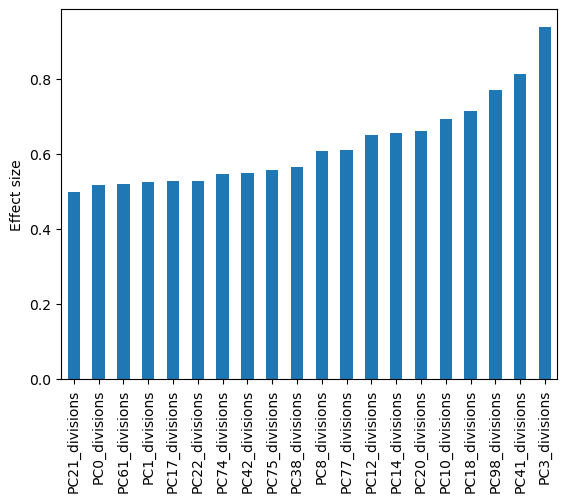

In [137]:
feat_names = divisions_pca.xs('PCA',level=1,axis=1).columns
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,feat_names[m[1].get_support()]] = m[2].coef_

importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(20).plot.bar()

plt.ylabel('Effect size')

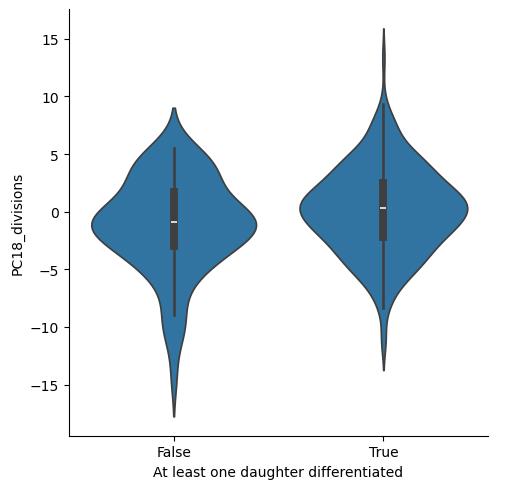

In [142]:
sb.catplot(divisions_pca.droplevel(axis=1,level=1),x=feature2predict,y='PC18_divisions',kind='violin')

# optimal features: 19
Index(['PC0_divisions', 'PC3_divisions', 'PC18_divisions', 'PC20_divisions',
       'PC22_divisions', 'PC23_divisions', 'PC28_divisions', 'PC36_divisions',
       'PC38_divisions', 'PC41_divisions', 'PC54_divisions', 'PC56_divisions',
       'PC68_divisions', 'PC71_divisions', 'PC86_divisions', 'PC92_divisions',
       'PC94_divisions', 'PC97_divisions', 'PC98_divisions'],
      dtype='object')


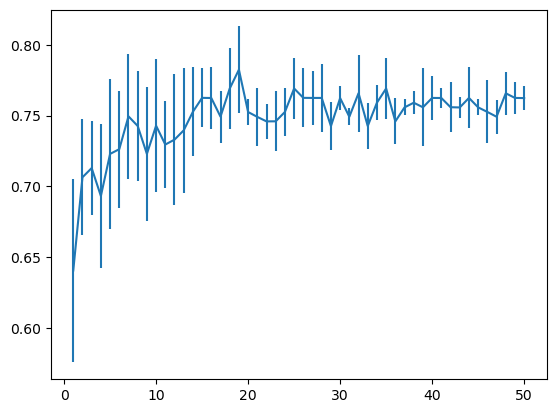

In [150]:
from sklearn import feature_selection

X = divisions_pca.xs('PCA',level=1,axis=1)
y = divisions_pca[feature2predict,'Meta'].astype(bool)
m = ensemble.RandomForestClassifier().fit(X,y)

results = feature_selection.RFECV(m).fit(X,y)

plt.errorbar(x=results.cv_results_['n_features'][:50],
        y=results.cv_results_['mean_test_score'][:50],
        yerr=results.cv_results_['std_test_score'][:50])
print(f'# optimal features: {results.n_features_}')
selected = X.columns[ results.ranking_ == 1]
print(selected)

In [1]:
results = feature_selection.SequentialFeatureSelector(m).fit(X,y)


NameError: name 'feature_selection' is not defined

In [160]:

selected = X.columns[ results.support_]
print(selected)
print(len(selected))


Index(['PC0_divisions', 'PC1_divisions', 'PC2_divisions', 'PC3_divisions',
       'PC4_divisions', 'PC7_divisions', 'PC8_divisions', 'PC12_divisions',
       'PC15_divisions', 'PC17_divisions', 'PC18_divisions', 'PC19_divisions',
       'PC20_divisions', 'PC23_divisions', 'PC24_divisions', 'PC25_divisions',
       'PC27_divisions', 'PC34_divisions', 'PC35_divisions', 'PC37_divisions',
       'PC38_divisions', 'PC40_divisions', 'PC44_divisions', 'PC46_divisions',
       'PC49_divisions', 'PC50_divisions', 'PC52_divisions', 'PC54_divisions',
       'PC55_divisions', 'PC58_divisions', 'PC59_divisions', 'PC60_divisions',
       'PC61_divisions', 'PC62_divisions', 'PC63_divisions', 'PC64_divisions',
       'PC68_divisions', 'PC70_divisions', 'PC73_divisions', 'PC74_divisions',
       'PC75_divisions', 'PC76_divisions', 'PC80_divisions', 'PC83_divisions',
       'PC85_divisions', 'PC93_divisions', 'PC95_divisions', 'PC96_divisions',
       'PC97_divisions', 'PC98_divisions'],
      dtype='ob

## Misc: visualizations

<Figure size 640x480 with 0 Axes>

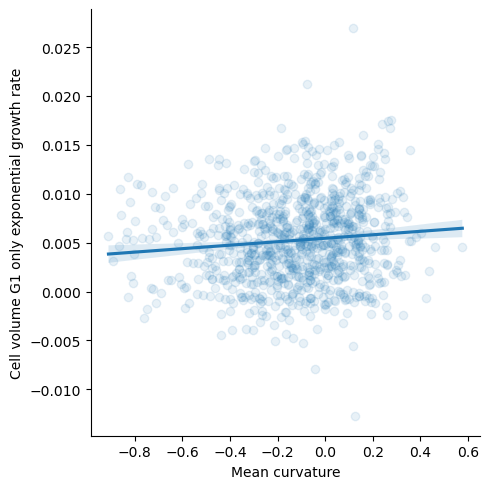

<Figure size 640x480 with 0 Axes>

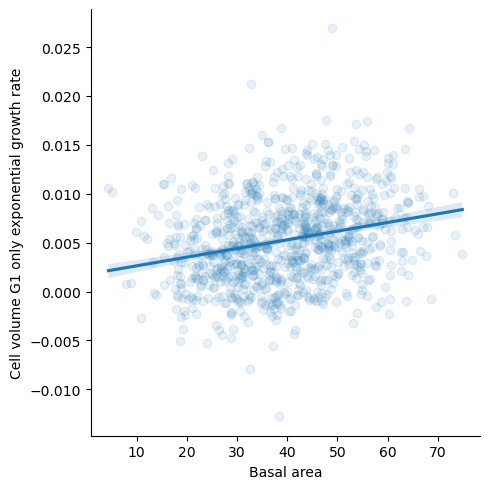

In [539]:
plt.figure()
x = 'Mean curvature'
y = 'Cell volume G1 only exponential growth rate'
sb.lmplot(all_df.droplevel(axis=1,level=1)[[x,y]].groupby('TrackID').mean(),x=x,y=y,
          scatter_kws={'alpha':0.1})

plt.figure()
x = 'Basal area'
y = 'Cell volume G1 only exponential growth rate'
sb.lmplot(all_df.droplevel(axis=1,level=1)[[x,y]].groupby('TrackID').mean(),x=x,y=y,
          scatter_kws={'alpha':0.1}, fit_reg=True)

In [227]:
features2drop = [f for f in all_df.droplevel(axis=1,level=1).columns if 'smoothed' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'shcoeffs' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'prior' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'standard' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'BM' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'intensity' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'Time' in f]
A = all_df.droplevel(axis=1,level=1).drop(
    columns=['X','X-pixels','Y','Y-pixels','X-cyto','Y-cyto','Z','Z-cyto',
             'Daughter a','Daughter b','Mother','Sister']+features2drop).select_dtypes(numerics).corr(numeric_only=True)

B = A.abs().unstack().sort_values(ascending=False)

unique_pairs = []
# Iterate over the top pairs and add only unique pairs to the list
for pair in B.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)

# Create a dataframe with the top pairs and their correlation coefficients
corr_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs):
    corr_df.loc[i] = [pair[0], pair[1], B.loc[pair[0], pair[1]]]

display(corr_df.dropna().head(50))


,feature_1,feature_2,corr_coef
0,Nuclear bbox bottom,Nuclear bbox top,0.979166
1,Nuclear volume exponential growth rate,Nuclear volume (filter_name) exponential growt...,0.919772
2,Cell volume exponential growth rate,Cell volume (filter_name) exponential growth rate,0.904737
3,Planar component 2,Planar component 1,0.823052
4,Axial component,Middle area,0.747579
5,Right,Left,0.747405
6,Mean curvature - cell coords,Nuclear bbox bottom,0.742856
7,Nuclear volume,Cell volume,0.731716
8,Nuclear bbox top,Mean curvature - cell coords,0.714124
9,Cell height,Planar component 1,0.693165
